# Multi-armed bandit with UCB

Random exploration gives us an opportunity to try out options that we have not known much about. However, due to the randomness, it is possible we end up exploring a bad action which we have confirmed in the past (bad luck!). To avoid such inefficient exploration, one approach is to decrease the parameter $\epsilon$ in time and the other is to be optimistic about options with high uncertainty and thus to prefer actions for which we haven’t had a confident value estimation yet. Or in other words, we favor exploration of actions with a strong potential to have a optimal value.

The Upper Confidence Bounds (UCB) algorithm measures this potential by an upper confidence bound of the reward value, $\widehat{U}_t(a)$, so that the true value is below with bound $Q(a)\leq \widehat{Q}_t(a) + \widehat{U}_t(a)$ with high probability. The upper bound $\widehat{U}_t(a)$ is a function of $N_t(a)$; a larger number of trials $N_t(a)$ should give us a smaller bound $\widehat{U}_t(a)$.

In UCB algorithm, we always select the greediest action to maximize the upper confidence bound:

$$ a_t^{UCB} = argmax{\widehat{Q}_t(a) + \widehat{U}_t(a)} $$

### Step 0. Import dependencies

In [1]:
import numpy as np
import pandas as pd
from functools import partial

### Step 1. Implementing Bandit class

In [2]:
class BanditUCB:
    def __init__(self, n, c):
        if c < 0:
            raise ValueError(f"""c needs to be > 0, you provide {c}""")
        self.c = c
        self.generators = []
        self.position = None
        self.stats = {
            'count': np.zeros(shape=(n,)),
            'cumulative_reward': np.zeros(shape=(n,)),
            'ucb': np.zeros(shape=(n,))
        }
        self.cols = [f"generator {i}" for i in range(n)]
        self.traces = pd.DataFrame(columns=self.cols)
        # generators for levers
        for i in range(n):
            mean = np.random.uniform(3, 6)
            variance = np.random.uniform(1, 6)
            self.generators.append(partial(np.random.normal, loc=mean, scale=variance))
            print(f"Generator {i}: mean {mean}, variance {variance}")

    def print_stats(self):
        print(f"Current levers count: {list(self.stats['count'])}")
        print(f"Current cumulative reward: {list(self.stats['cumulative_reward'])}")
        print(f"Current UCB bounds: {list(self.stats['ucb'])}")

    def sample(self):
        self.position = np.argmax(self.stats['ucb'])

    def update(self, t):
        value = self.generators[self.position]()
        self.stats['count'][self.position] += 1
        self.stats['cumulative_reward'][self.position] += value
        self.stats['ucb'] = self.stats['cumulative_reward'] / (self.stats['count'] + 0.001) + self.c * np.sqrt(
            np.log(t) / (self.stats['count'] + 0.001))
        current_traces = pd.DataFrame(self.stats['ucb'].reshape(1, -1), columns=self.cols)
        self.traces = pd.concat((self.traces, current_traces)).reset_index(drop=True)

    def plot_traces(self):
        self.traces.plot(figsize=(20, 10))

Let's create example of our Bandit class and simulate 100 times

In [3]:
bandit = BanditUCB(10, 4)
for i in range(1, 100):
    bandit.sample()
    bandit.update(i)

Generator 0: mean 3.056612282381729, variance 2.969099301094887
Generator 1: mean 5.740911594858721, variance 5.38506233151781
Generator 2: mean 3.4231148557700397, variance 5.848079605865077
Generator 3: mean 4.942614067625309, variance 4.706804957810393
Generator 4: mean 3.31566881663827, variance 5.009080327089818
Generator 5: mean 4.509805279427816, variance 1.3677046447875576
Generator 6: mean 3.4893171518463957, variance 3.9530365208231757
Generator 7: mean 5.0708007718978125, variance 5.344548421135174
Generator 8: mean 5.879776787784164, variance 5.420961407675894
Generator 9: mean 4.386754297054144, variance 1.8355594364957541


We can look on stats...

In [4]:
bandit.print_stats()

Current levers count: [3.0, 29.0, 25.0, 15.0, 1.0, 9.0, 1.0, 7.0, 5.0, 4.0]
Current cumulative reward: [8.475719539260522, 175.7618007398072, 158.27761338699432, 78.90288460554977, -1.672315530415251, 43.100243295165455, -5.713818057697641, 31.725275848496352, 15.98367908713088, 11.092208298164822]
Current UCB bounds: [7.773958956274626, 7.652758554496973, 8.045715457482995, 7.473692240099554, 6.89956334607238, 7.6463891936947705, 2.8620982838522098, 7.772156887463189, 7.030342708071894, 7.059069311978435]


And look on plot. Do you see anything strange? How could you explain this peak on plot? Let's think about it

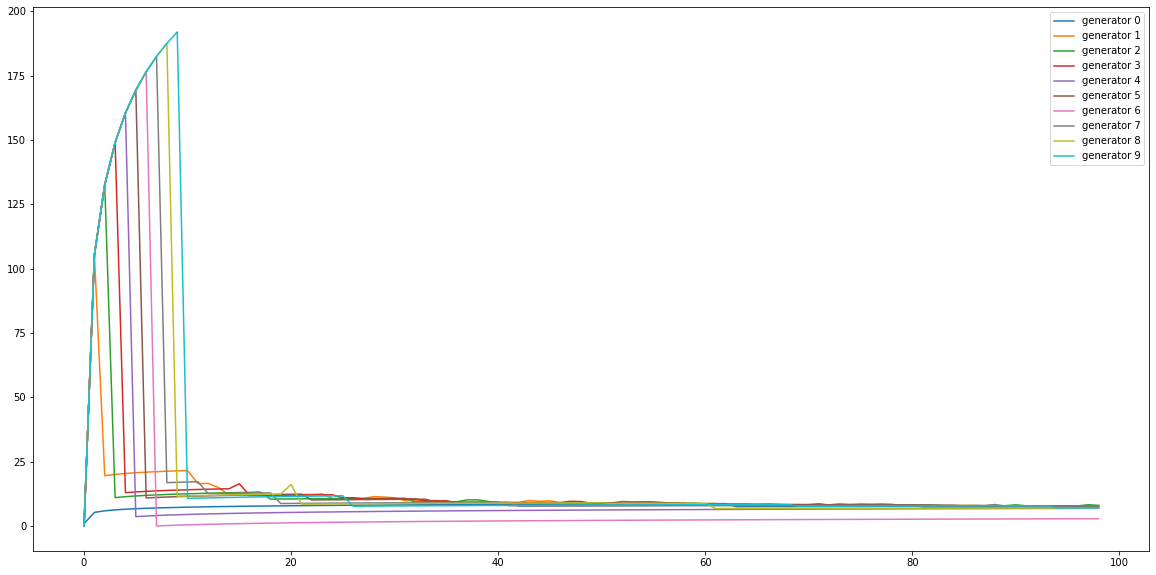

In [5]:
bandit.plot_traces()